# Измерение производительности JIT-компиляции

Будут сравниваться три подхода:
1. Питон без улучшений
2. С аннотацией `@jit`
3. С аннотацией `@numba.jit`

In [1]:
from annotation import jit
from timeit import timeit, repeat
import numba

import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_jit_numba_realisations(func):
    """По входной функции возвращает две оптимизации"""
    jit_func = jit(func)
    numba_func = numba.jit(func, nopython=True)
    return jit_func, numba_func

## Замеры времени компиляции

In [3]:
def py_sum(x: int, y: int) -> int:
    res: int = x + y
    return res

In [4]:
jit_time = repeat(lambda: jit(py_sum), repeat=10, number=1)
jit_time

[0.1940489999979036,
 0.06747579999500886,
 0.06736960000125691,
 0.06804439998813905,
 0.06601549999322742,
 0.06757149999612011,
 0.06684990000212565,
 0.0692879999987781,
 0.06576969999878202,
 0.06609530000423547]

In [5]:
numba_jit_time = repeat(lambda: numba.jit(py_sum), repeat=10, number=1)
numba_jit_time

[0.4413692000089213,
 0.00014910000027157366,
 9.830000635702163e-05,
 9.279999358113855e-05,
 8.739999611862004e-05,
 8.55999969644472e-05,
 8.55999969644472e-05,
 9.250000584870577e-05,
 9.180000051856041e-05,
 9.14999982342124e-05]

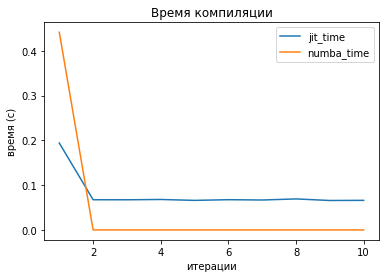

In [7]:
xs = range(1, 11)
plt.plot(xs, jit_time, label='jit_time')
plt.plot(xs, numba_jit_time, label='numba_time')
plt.xlabel('итерации')
plt.ylabel('время (с)')
plt.title('Время компиляции')
plt.legend()
plt.savefig("report/plots/compile_sum.png")
plt.show()

Выводы:
* Компиляция в @numba.jit происходит быстрее в 5 раз
* @numba.jit не выполняет повторную компиляцию модуля, за счёт чего экономит время

## Замеры времени нескольких вызовов

In [8]:
jit_sum = jit(py_sum)
numba_sum = numba.jit(py_sum)

python_exec_time = repeat(lambda: py_sum(2, 2), repeat=10, number=1)
print(python_exec_time)
jit_exec_time = repeat(lambda: jit_sum(2, 2), repeat=10, number=1)
print(jit_exec_time)
numba_exec_time = repeat(lambda: numba_sum(2, 2), repeat=10, number=1)
print(numba_exec_time)

[1.1999945854768157e-06, 3.00002284348011e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 1.9998697098344564e-07, 2.00001522898674e-07]
[6.700007361359894e-06, 8.00006091594696e-07, 2.2999884095042944e-06, 6.00004568696022e-07, 5.00003807246685e-07, 1.1999945854768157e-06, 2.3000029614195228e-06, 6.00004568696022e-07, 5.999900167807937e-07, 5.00003807246685e-07]
[0.396021100008511, 6.200003554113209e-06, 4.00003045797348e-07, 3.00002284348011e-07, 3.00002284348011e-07, 3.00002284348011e-07, 3.00002284348011e-07, 2.00001522898674e-07, 3.00002284348011e-07, 2.00001522898674e-07]


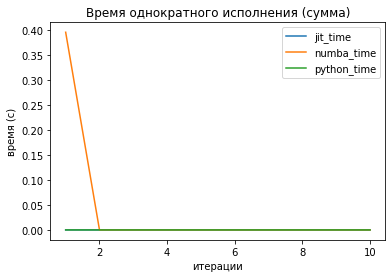

In [9]:
xs = range(1, 11)
plt.plot(xs, jit_exec_time, label='jit_time')
plt.plot(xs, numba_exec_time, label='numba_time')
plt.plot(xs, python_exec_time, label='python_time')
plt.xlabel('итерации')
plt.ylabel('время (с)')
plt.title('Время однократного исполнения (сумма)')
plt.legend()
plt.savefig("report/plots/exec_sum_once.png")
plt.show()

Выводы:
* У функции с аннотацией @numba.jit неприлично большое время первого запуска. Видимо, при первом запуске
выполняются некоторые этапы компиляции.

## Усреднённые значения вызовов на простой функции

In [10]:
python_exec_time = repeat(lambda: py_sum(2, 2), repeat=10, number=1000000)
print(python_exec_time)
print(np.var(python_exec_time))
jit_exec_time = repeat(lambda: jit_sum(2, 2), repeat=10, number=1000000)
print(jit_exec_time)
print(np.var(jit_exec_time))
numba_exec_time = repeat(lambda: numba_sum(2, 2), repeat=10, number=1000000)
print(numba_exec_time)
print(np.var(numba_exec_time))

[0.09933900000760332, 0.09758259999216534, 0.09792319999542087, 0.13881960000435356, 0.1066729000012856, 0.09973859999445267, 0.09839250000368338, 0.09850459999870509, 0.09824479999952018, 0.09840020000410732]
0.00014595944829967625
[0.4505159999971511, 0.4504622000094969, 0.4478960999986157, 0.44896689998859074, 0.4525863000017125, 0.4504758999974001, 0.44973940000636503, 0.45296979999693576, 0.44746520000626333, 0.4485159999894677]
3.0387595774960727e-06
[0.16232010000385344, 0.1628123999980744, 0.16361799999140203, 0.16127930000948254, 0.1551534000027459, 0.15684409999812488, 0.15780739999900106, 0.15516260000003967, 0.15526329999556765, 0.1554448999959277]
1.1242815004587455e-05


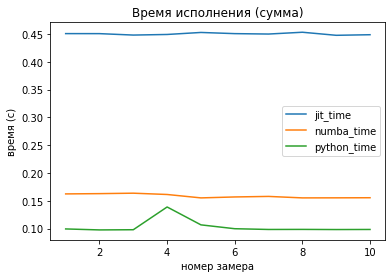

In [11]:
xs = range(1, 11)
plt.plot(xs, jit_exec_time, label='jit_time')
plt.plot(xs, numba_exec_time, label='numba_time')
plt.plot(xs, python_exec_time, label='python_time')
plt.xlabel('номер замера')
plt.ylabel('время (с)')
plt.title('Время исполнения (сумма)')
plt.legend()
plt.savefig("report/plots/exec_sum.png")
plt.show()

Выводы:
* На простых функциях питон без jit-компиляции выполняется быстрее, чем с ней.
* И всё-таки на простых функциях numba проигрывает Питону в 1,5 раза, а ручная jit аннотация в 4,5.

## Измерение скорости выполнения

### Функция вычисления экспоненты с помощью разложения в ряд Тейлора

In [12]:
def py_exp(x: float) -> float:
    res: float = 0
    threshold: float = 1e-30
    delta: float = 1
    elements: int = 0
    while delta > threshold:
        elements = elements + 1
        delta = delta * x / elements
    while elements >= 0:
        res += delta
        delta = delta * elements / x
        elements -= 1
    return res

jit_exp, numba_exp = get_jit_numba_realisations(py_exp)


In [13]:
arg = 250
print(f"exp({arg}) = {jit_exp(arg):.30f}")
args = range(10, 260, 10)
jit_exp_time, numba_exp_time, python_exp_time = [], [], []
for arg in args:
    jit_exp_time.append(timeit(lambda: jit_exp(arg), number=10000))
    numba_exp_time.append(timeit(lambda: numba_exp(arg), number=10000))
    python_exp_time.append(timeit(lambda: py_exp(arg), number=10000))
print(jit_exp_time)
print(numba_exp_time)
print(python_exp_time)

exp(250) = 3746454614502660877998657881484689260451454624001099543290316630153610787704025897267034669677141296546840576.000000000000000000000000000000
[0.008659699989948422, 0.011550800001714379, 0.013594300005934201, 0.01612339999701362, 0.01807130000088364, 0.021773200001916848, 0.022235600001295097, 0.02405989999533631, 0.026236099991365336, 0.028220299995155074, 0.030320299993036315, 0.0324490000057267, 0.034540500011644326, 0.03645090000645723, 0.03831839999475051, 0.04037780000362545, 0.04248689999803901, 0.04617780000262428, 0.04640649999782909, 0.04845990000467282, 0.05029919999651611, 0.05236210000293795, 0.05458290000387933, 0.0571885000099428, 0.05905799999891315]
[0.09945670000161044, 0.00935849999950733, 0.011757600004784763, 0.014187399996444583, 0.01622489999863319, 0.01889770000707358, 0.020455500009120442, 0.02217350000864826, 0.0245633999875281, 0.026237600002787076, 0.028509300012956373, 0.030767599993851036, 0.032875399992917664, 0.034908000001451, 0.03660959999251

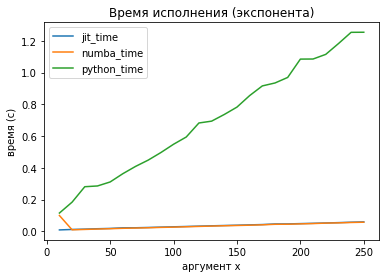

In [14]:
plt.plot(args, jit_exp_time, label='jit_time')
plt.plot(args, numba_exp_time, label='numba_time')
plt.plot(args, python_exp_time, label='python_time')
plt.xlabel('аргумент x')
plt.ylabel('время (с)')
plt.title('Время исполнения (экспонента)')
plt.legend()
plt.savefig("report/plots/exec_exp_3.png")
plt.show()

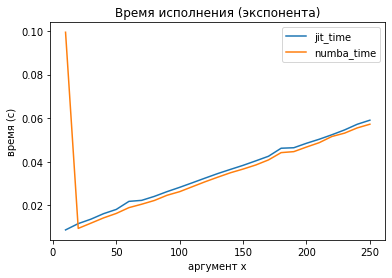

In [16]:
plt.plot(args, jit_exp_time, label='jit_time')
plt.plot(args, numba_exp_time, label='numba_time')
plt.xlabel('аргумент x')
plt.ylabel('время (с)')
plt.title('Время исполнения (экспонента)')
plt.legend()
plt.savefig("report/plots/exec_exp_2.png")
plt.show()

Выводы:
* Аномалия первого запуска numba функции была обсуждена ранее
* На больших алгоритмических сложностях питон сдаёт позиции
* Отличие производительности двух методов оптимизации незначительно на больших значениях аргумента

### Простая хеш-функция для целых чисел

In [17]:
def py_hash(x: int) -> int:
    x = ((x >> 16) ^ x) * 0x45d9f3b
    x = ((x >> 16) ^ x) * 0x45d9f3b
    x = (x >> 16) ^ x
    return x


jit_hash, numba_hash = get_jit_numba_realisations(py_hash)

In [18]:
python_exec_time = repeat(lambda: py_hash(42), repeat=10, number=1000000)
print(python_exec_time)
jit_exec_time = repeat(lambda: jit_hash(42), repeat=10, number=1000000)
print(jit_exec_time)
numba_exec_time = repeat(lambda: numba_hash(42), repeat=10, number=1000000)
print(numba_exec_time)

[0.37007980000635143, 0.3758099999977276, 0.3633047000039369, 0.35190020001027733, 0.3498856999940472, 0.3487064999935683, 0.3480552999972133, 0.3483235000021523, 0.35076840000692755, 0.34264689999690745]
[0.3387545000005048, 0.34049979998962954, 0.337739499998861, 0.34000309999100864, 0.33302519998687785, 0.3405728999932762, 0.3381670000089798, 0.34021690000372473, 0.33980590000282973, 0.333887800006778]
[0.2055982000019867, 0.16841440000280272, 0.169121200000518, 0.16380960000969935, 0.16161019999708515, 0.16090640000766143, 0.16165679998812266, 0.16384589999506716, 0.16245200000412297, 0.16169430001173168]


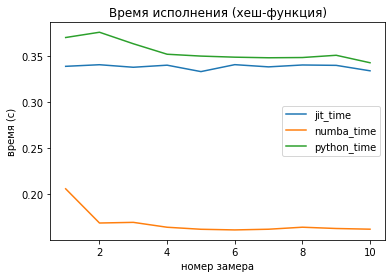

In [19]:
xs = range(1, 11)
plt.plot(xs, jit_exec_time, label='jit_time')
plt.plot(xs, numba_exec_time, label='numba_time')
plt.plot(xs, python_exec_time, label='python_time')
plt.xlabel('номер замера')
plt.ylabel('время (с)')
plt.title('Время исполнения (хеш-функция)')
plt.legend()
plt.savefig("report/plots/exec_hash.png")
plt.show()

Выводы:
* То что функция @jit работает примерно с такой же скоростью, как и питон, не вызывает вопросов
* Но откуда у numba оптимизация на битовых операциях (?)

### Числа Фибоначчи

In [10]:
def py_fib(n: int) -> int:
    if n < 2:
        return 1
    return py_fib(n - 1) + py_fib(n - 2)

@jit
def jit_fib(n: int) -> int:
    if n < 2:
        return 1
    return jit_fib(n - 1) + jit_fib(n - 2)

@numba.jit(nopython=True)
def numba_fib(n: int) -> int:
    if n < 2:
        return 1
    return numba_fib(n - 1) + numba_fib(n - 2)

Module(
    body=[
        FunctionDef(
            name='jit_fib',
            args=arguments(
                posonlyargs=[],
                args=[
                    arg(
                        arg='n',
                        annotation=Name(id='int', ctx=Load()))],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                If(
                    test=Compare(
                        left=Name(id='n', ctx=Load()),
                        ops=[
                            Lt()],
                        comparators=[
                            Constant(value=2)]),
                    body=[
                        Return(
                            value=Constant(value=1))],
                    orelse=[]),
                Return(
                    value=BinOp(
                        left=Call(
                            func=Name(id='jit_fib', ctx=Load()),
                            args=[
               

In [11]:
arg = 30
print(f"fib({arg}) = {jit_fib(arg)}")
args = range(1, 31)
jit_fib_time, numba_fib_time, python_fib_time = [], [], []
for arg in args:
    jit_fib_time.append(timeit(lambda: jit_fib(arg), number=10))
    numba_fib_time.append(timeit(lambda: numba_fib(arg), number=10))
    python_fib_time.append(timeit(lambda: py_fib(arg), number=10))
print(jit_fib_time)
print(numba_fib_time)
print(python_fib_time)

fib(30) = 1346269
[8.500006515532732e-06, 6.099988240748644e-06, 4.7000066842883825e-06, 4.6000059228390455e-06, 4.7000066842883825e-06, 4.7000066842883825e-06, 4.8000074457377195e-06, 5.3000112529844046e-06, 5.4000120144337416e-06, 5.599984433501959e-06, 6.300018867477775e-06, 7.399998139590025e-06, 9.000010322779417e-06, 1.09999964479357e-05, 1.4599994756281376e-05, 2.2499996703118086e-05, 3.120000474154949e-05, 5.509998300112784e-05, 7.909999112598598e-05, 0.00014830002328380942, 0.00021109997760504484, 0.00037910000537522137, 0.0005507000023499131, 0.0010009999969042838, 0.0014273000124376267, 0.0024482000153511763, 0.003626799996709451, 0.0061200000054668635, 0.009229299990693107, 0.01521899999352172]
[0.05249370000092313, 2.700020559132099e-06, 2.500019036233425e-06, 2.3999891709536314e-06, 2.6999914553016424e-06, 2.900022082030773e-06, 3.2999960239976645e-06, 3.9000005926936865e-06, 4.8000074457377195e-06, 6.299989763647318e-06, 8.69997893460095e-06, 1.2800010154023767e-05, 1.93

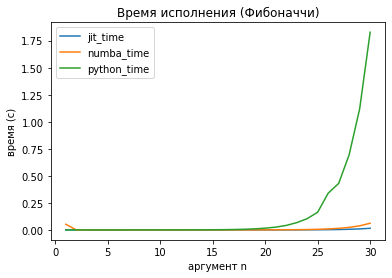

In [12]:
plt.plot(args, jit_fib_time, label='jit_time')
plt.plot(args, numba_fib_time, label='numba_time')
plt.plot(args, python_fib_time, label='python_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (Фибоначчи)')
plt.legend()
plt.savefig("report/plots/exec_fib_3.png")
plt.show()

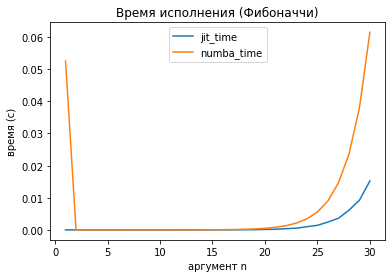

In [13]:
plt.plot(args, jit_fib_time, label='jit_time')
plt.plot(args, numba_fib_time, label='numba_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (Фибоначчи)')
plt.legend()
plt.savefig("report/plots/exec_fib_2.png")
plt.show()

Выводы:
* На задачах рекурсии реализованный алгоритм показывается себя не так уж и плохо
(до 4-кратного ускорения на данном примере)

### Функция факториала

In [30]:
def py_fact(n: int) -> int:
    if n < 2:
        return 1
    return n * py_fact(n - 1)

@jit
def jit_fact(n: int) -> int:
    if n < 2:
        return 1
    return n * jit_fact(n - 1)

@numba.jit
def numba_fact(n: int) -> int:
    if n < 2:
        return 1
    return n * numba_fact(n - 1)

In [34]:
arg = 10
print(f"fib({arg}) = {jit_fact(arg)}")
args = range(1, 40)
jit_fact_time, numba_fact_time, python_fact_time = [], [], []
for arg in args:
    jit_fact_time.append(timeit(lambda: jit_fact(arg), number=10))
    numba_fact_time.append(timeit(lambda: numba_fact(arg), number=10))
    python_fact_time.append(timeit(lambda: py_fact(arg), number=10))
print(jit_fact_time)
print(numba_fact_time)
print(python_fact_time)

fib(10) = 3628800
[2.4999957531690598e-05, 7.300055585801601e-06, 7.2999391704797745e-06, 8.299946784973145e-06, 7.00005330145359e-06, 7.300055585801601e-06, 8.800067007541656e-06, 8.800067007541656e-06, 2.2500054910779e-05, 1.9400031305849552e-05, 9.299954399466515e-06, 9.499955922365189e-06, 9.499955922365189e-06, 9.400071576237679e-06, 7.79994297772646e-06, 5.179992876946926e-05, 9.699957445263863e-06, 7.409998215734959e-05, 9.00006853044033e-06, 8.00006091594696e-06, 7.4999406933784485e-06, 7.400056347250938e-06, 7.300055585801601e-06, 7.200054824352264e-06, 7.899943739175797e-06, 7.500057108700275e-06, 7.79994297772646e-06, 7.800059393048286e-06, 7.6000578701496124e-06, 7.699942216277122e-06, 9.299954399466515e-06, 7.800059393048286e-06, 7.300055585801601e-06, 7.2999391704797745e-06, 7.0999376475811005e-06, 7.0999376475811005e-06, 7.1999384090304375e-06, 7.699942216277122e-06, 7.100054062902927e-06]
[6.200047209858894e-06, 2.300017513334751e-06, 2.200016751885414e-06, 2.3000175133

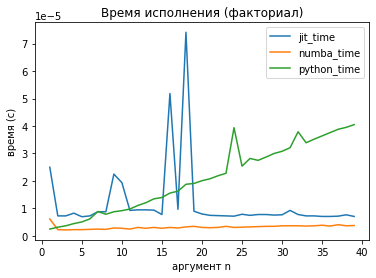

In [35]:
plt.plot(args, jit_fact_time, label='jit_time')
plt.plot(args, numba_fact_time, label='numba_time')
plt.plot(args, python_fact_time, label='python_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (факториал)')
plt.legend()
plt.savefig("report/plots/exec_fact_3.png")
plt.show()

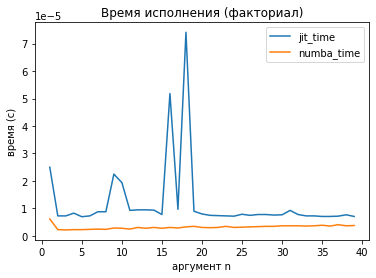

In [36]:
plt.plot(args, jit_fact_time, label='jit_time')
plt.plot(args, numba_fact_time, label='numba_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (факториал)')
plt.legend()
plt.savefig("report/plots/exec_fact_3.png")
plt.show()

### Функция поиска n-го простого числа (наивная реализация)

In [24]:
def py_n_primary(n: int) -> int:
    count: int = 0
    number: int = 2
    while count < n:
        i: int = 2
        is_prime: bool = True
        while i < number:
            if number % i == 0:
                is_prime = False
                break
            i += 1
        if is_prime:
            count += 1
        number += 1
    return number - 1


jit_n_primary, numba_n_primary = get_jit_numba_realisations(py_n_primary)

In [25]:
arg = 1000
print(f"prim({arg}) = {jit_n_primary(arg)}")
args = range(10, 2010, 100)
jit_n_primary_time, numba_n_primary_time, python_n_primary_time = [], [], []
for arg in args:
    jit_n_primary_time.append(timeit(lambda: jit_n_primary(arg), number=1))
    numba_n_primary_time.append(timeit(lambda: numba_n_primary(arg), number=1))
    python_n_primary_time.append(timeit(lambda: py_n_primary(arg), number=1))
print(jit_n_primary_time)
print(numba_n_primary_time)
print(python_n_primary_time)

exp(1000) = 7919
[8.999995770864189e-06, 0.00010540000221226364, 0.00042550000944174826, 0.0010045999952126294, 0.0018210999987786636, 0.0029282000032253563, 0.004290900003979914, 0.006054400000721216, 0.008000299989362247, 0.010310099998605438, 0.013112200002069585, 0.01569770000060089, 0.01892729999963194, 0.02229889998852741, 0.026247200003126636, 0.030265199995483272, 0.03508099999453407, 0.03956650001055095, 0.0444195000018226, 0.049460499998531304]
[0.06503009999869391, 0.00010660001134965569, 0.0004295999970054254, 0.0010209999891230837, 0.001847699997597374, 0.002937099998234771, 0.00432110000110697, 0.006321399996522814, 0.008001100010005757, 0.010253300002659671, 0.013107000006129965, 0.01561700001184363, 0.01884730000165291, 0.022194099990883842, 0.026426500000525266, 0.03040750000218395, 0.034459999995306134, 0.03920170001219958, 0.044064300003810786, 0.04933939999318682]
[9.399998816661537e-06, 0.0013140000082785264, 0.005873500005691312, 0.01407229999313131, 0.02715880000

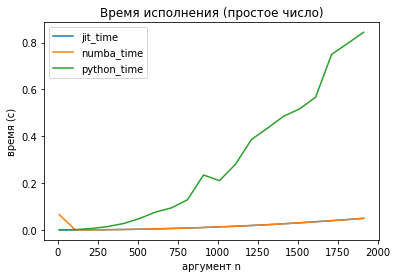

In [26]:
plt.plot(args, jit_n_primary_time, label='jit_time')
plt.plot(args, numba_n_primary_time, label='numba_time')
plt.plot(args, python_n_primary_time, label='python_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (простое число)')
plt.legend()
plt.savefig("report/plots/exec_prim_3.png")
plt.show()

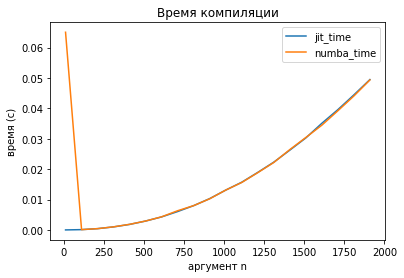

In [27]:
plt.plot(args, jit_n_primary_time, label='jit_time')
plt.plot(args, numba_n_primary_time, label='numba_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время компиляции')
plt.legend()
plt.savefig("report/plots/exec_prim_2.png")
plt.show()

Выводы:
* Аналогичны выводам по экспоненте